In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

### 1D example

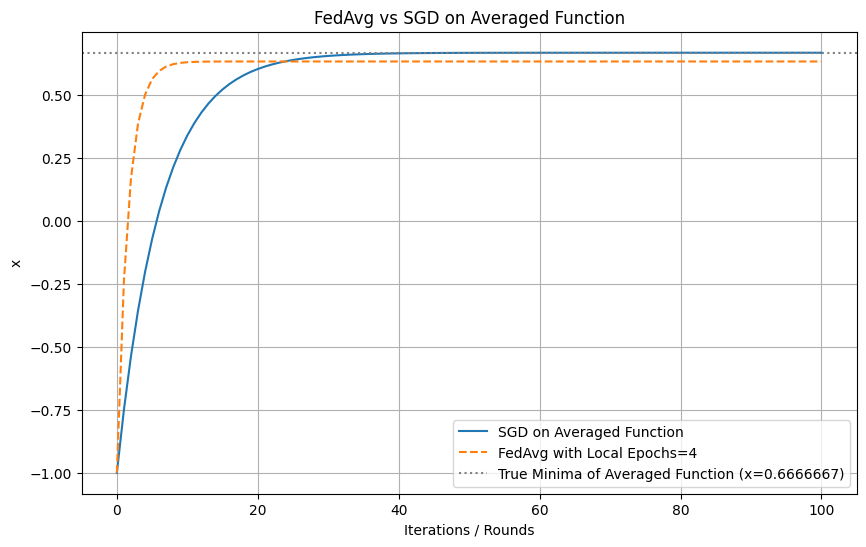

In [229]:
import torch
import matplotlib.pyplot as plt

# Define two convex functions for two clients
def client1_function(x):
    return (x - 1) ** 2  # Global minima at x = 1

def client2_function(x):
    return 0.5*(x ) ** 2  # Global minima at x = 0

# Average function
def averaged_function(x):
    return 0.5 * ((x - 1) ** 2 + 0.5*(x) ** 2)

# SGD on the averaged function
def sgd_on_global_function(learning_rate=0.1, steps=100):
    x = torch.tensor(-1.0, requires_grad=True)
    trajectory = [x.item()]
    optimizer = torch.optim.SGD([x], lr=learning_rate)

    for _ in range(steps):
        optimizer.zero_grad()
        loss = averaged_function(x)
        loss.backward()
        optimizer.step()
        trajectory.append(x.item())

    return trajectory, x.item()

# FedAvg simulation with local training
def fedavg(learning_rate=0.1, global_rounds=100, local_epochs=4):
    client1_x = torch.tensor(-1.0, requires_grad=True)
    client2_x = torch.tensor(-1.0, requires_grad=True)
    global_x = -1.0  # Initial global value
    trajectory = [global_x]

    for _ in range(global_rounds):
        # Local training on client 1
        optimizer1 = torch.optim.SGD([client1_x], lr=learning_rate)
        for _ in range(local_epochs):
            optimizer1.zero_grad()
            loss1 = client1_function(client1_x)
            loss1.backward()
            optimizer1.step()

        # Local training on client 2
        optimizer2 = torch.optim.SGD([client2_x], lr=learning_rate)
        for _ in range(local_epochs):
            optimizer2.zero_grad()
            loss2 = client2_function(client2_x)
            loss2.backward()
            optimizer2.step()

        # Federated averaging
        global_x = (client1_x.item() + client2_x.item()) / 2
        trajectory.append(global_x)

        # Reset clients' values to global value
        client1_x = torch.tensor(global_x, requires_grad=True)
        client2_x = torch.tensor(global_x, requires_grad=True)

    return trajectory

# Plot the results
global_trajectory, final_global_x = sgd_on_global_function()
fedavg_trajectory = fedavg()

plt.figure(figsize=(10, 6))
plt.plot(global_trajectory, label="SGD on Averaged Function")
plt.plot(fedavg_trajectory, label="FedAvg with Local Epochs=4", linestyle="--")
plt.axhline(y=2/3, color='gray', linestyle=':', label="True Minima of Averaged Function (x=0.6666667)")
plt.title("FedAvg vs SGD on Averaged Function")
plt.xlabel("Iterations / Rounds")
plt.ylabel("x")
plt.legend()
plt.grid(True)
plt.show()


### 2D example

In [219]:
def f1(W):
    return 0.5 * (W[0] - 15)**2 + (W[1])**2  # Minima at (15, 0)

def f2(W):
    return 2 * (W[0] + 12)**2 + 0.7 * (W[1] + 15)**2  # Minima at (-12, -15)

def f(W):
    return 0.5 * (f1(W) + f2(W))


w1 = np.linspace(-20, 20, 300)
w2 = np.linspace(-20, 20, 300)
W1, W2 = np.meshgrid(w1, w2)
Z1 = f1(np.array([W1, W2]))
Z2 = f2(np.array([W1, W2]))
Z = f(np.array([W1, W2]))

In [226]:
def sgd_global_function(w=None, learning_rate=0.0001, steps=1000):
    if w is None:
        w = torch.tensor([10.0, 15.0], requires_grad=True)
    trajectory = [w.detach().numpy().copy()]  # Make a copy here

    optimizer = torch.optim.SGD([w], lr=learning_rate)

    for _ in range(steps):
        optimizer.zero_grad()
        loss = f(w) 
        loss.backward()
        optimizer.step()
        trajectory.append(w.detach().numpy().copy())  # Make a copy here

    return trajectory, w

def fedavg(w=None, learning_rate=0.0001, steps=30, local_steps=30):
    if w is None:
        w = torch.tensor([10.0, 15.0], requires_grad=True)
    
    trajectory = [w.detach().numpy().copy()]  # Copy the initial value
    client_1_trajectory = [w.detach().numpy().copy()]
    client_2_trajectory = [w.detach().numpy().copy()]
    client_1_w = torch.tensor(w.detach().numpy(), requires_grad=True)
    client_2_w = torch.tensor(w.detach().numpy(), requires_grad=True)
    
    for _ in range(steps):
        # Local training on client 1
        optimizer1 = torch.optim.SGD([client_1_w], lr=learning_rate)
        for epoch in range(local_steps):
            optimizer1.zero_grad()
            loss1 = f1(client_1_w) 
            loss1.backward()
            optimizer1.step()
            client_1_trajectory.append(client_1_w.detach().numpy().copy())

        # Local training on client 2
        optimizer2 = torch.optim.SGD([client_2_w], lr=learning_rate)
        for epoch in range(local_steps):
            optimizer2.zero_grad()
            loss2 = f2(client_2_w)
            loss2.backward()
            optimizer2.step()
            client_2_trajectory.append(client_2_w.detach().numpy().copy())

        # Federated averaging
        w = (client_1_w.detach().numpy() + client_2_w.detach().numpy()) / 2
        trajectory.append(w.copy())  # Copy the averaged value
        
        # Reset clients' values to global value
        client_1_w = torch.tensor(w, requires_grad=True)
        client_2_w = torch.tensor(w, requires_grad=True)

        client_1_trajectory.append(w.copy())
        client_2_trajectory.append(w.copy())

    return trajectory, w, client_1_trajectory, client_2_trajectory


In [314]:
global_trajectory, final_global_x = sgd_global_function(learning_rate=0.1, steps=200)
fedavg_trajectory, final_fedavg_x, client_1_traj, client_2_traj = fedavg(learning_rate=0.1, steps=200, local_steps=4)

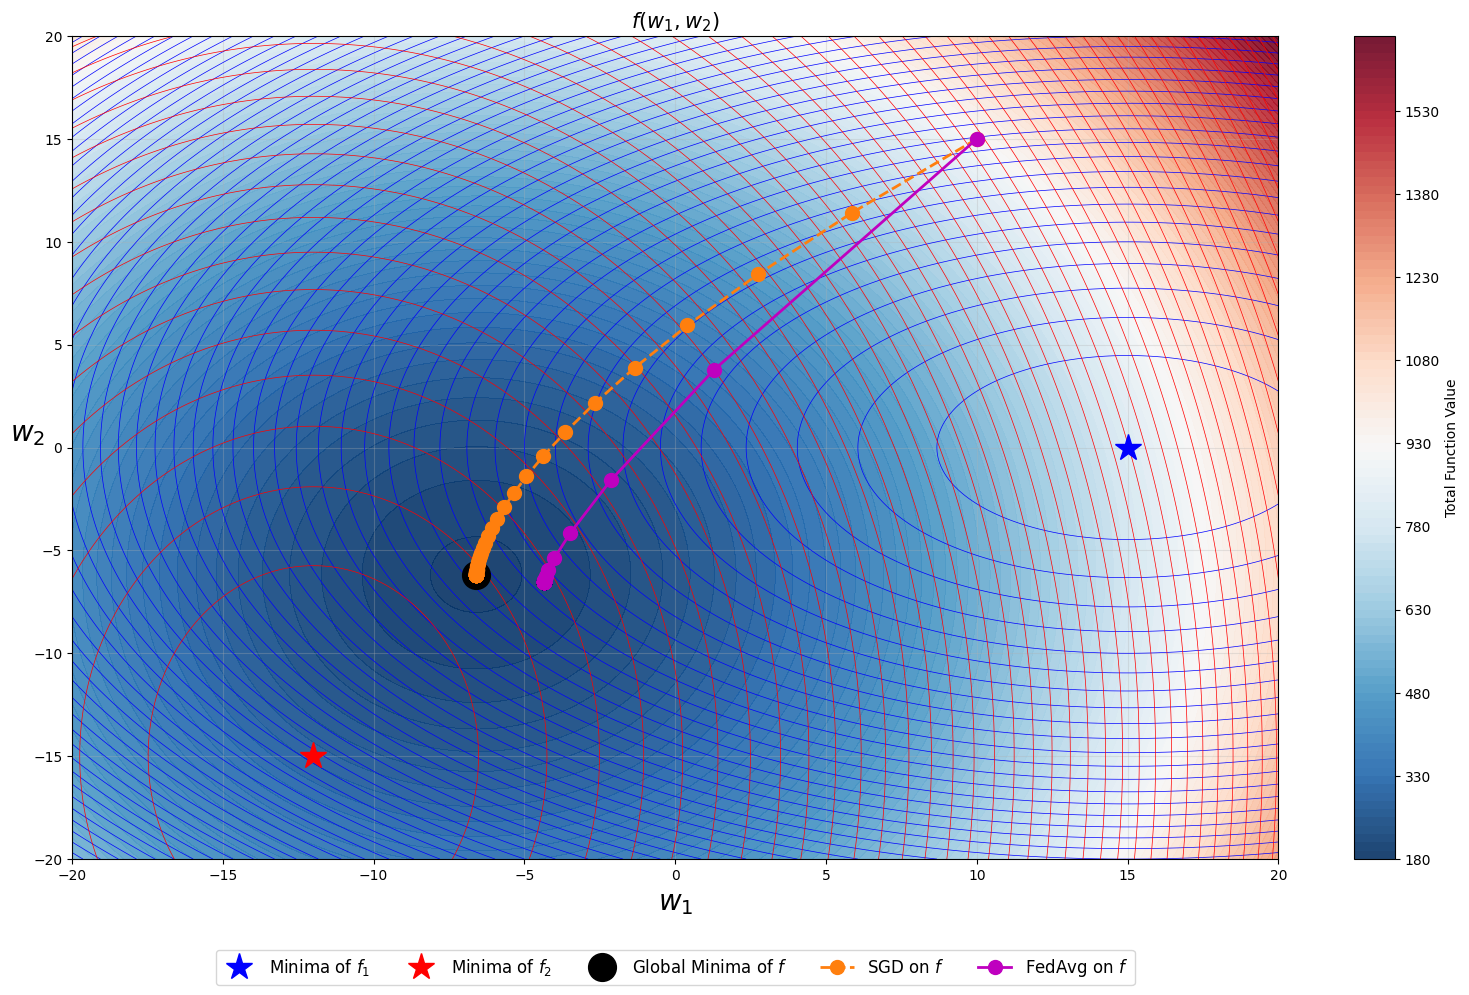

In [344]:
plt.figure(figsize=(16, 10))

contour_lines_1 =  plt.contour(W1, W2, Z1, levels=50, colors='blue', linewidths=0.5)
contour_lines_2 =  plt.contour(W1, W2, Z2, levels=50, colors='red', linewidths=0.5)
plt.plot(15, 0, 'b*', markersize=20, label=f'Minima of $f_1$')
plt.plot(-12, -15, 'r*', markersize=20, label=f'Minima of $f_2$')

contour = plt.contourf(W1, W2, Z, levels=100, cmap='RdBu_r', alpha=0.9)
plt.colorbar(contour, label='Total Function Value', orientation='vertical')
plt.plot(-6.59999996, -6.17647155, 'ko', markersize=20, label=f'Global Minima of $f$')

#SGD
SGD_W1 = [x[0] for x in global_trajectory]
SGD_W2 = [x[1] for x in global_trajectory]
plt.plot(SGD_W1, SGD_W2, '--o', color='tab:orange', label='SGD on $f$', linewidth=2, markersize=10)

#FedAvg
FedAvg_W1 = [x[0] for x in fedavg_trajectory]
FedAvg_W2 = [x[1] for x in fedavg_trajectory]
plt.plot(FedAvg_W1[::], FedAvg_W2[::], 'm-o', label='FedAvg on $f$', linewidth=2, markersize=10)


plt.title("$f(w_1, w_2)$", fontsize=15)
plt.xlabel("$w_1$", fontsize=20)
plt.ylabel("$w_2$", rotation=0, fontsize=20)
plt.legend(
    fontsize=12,                
    loc='upper center',         
    bbox_to_anchor=(0.5, -0.1), 
    ncol=6                      
)
plt.grid(alpha=0.3)
plt.tight_layout()  
plt.show()

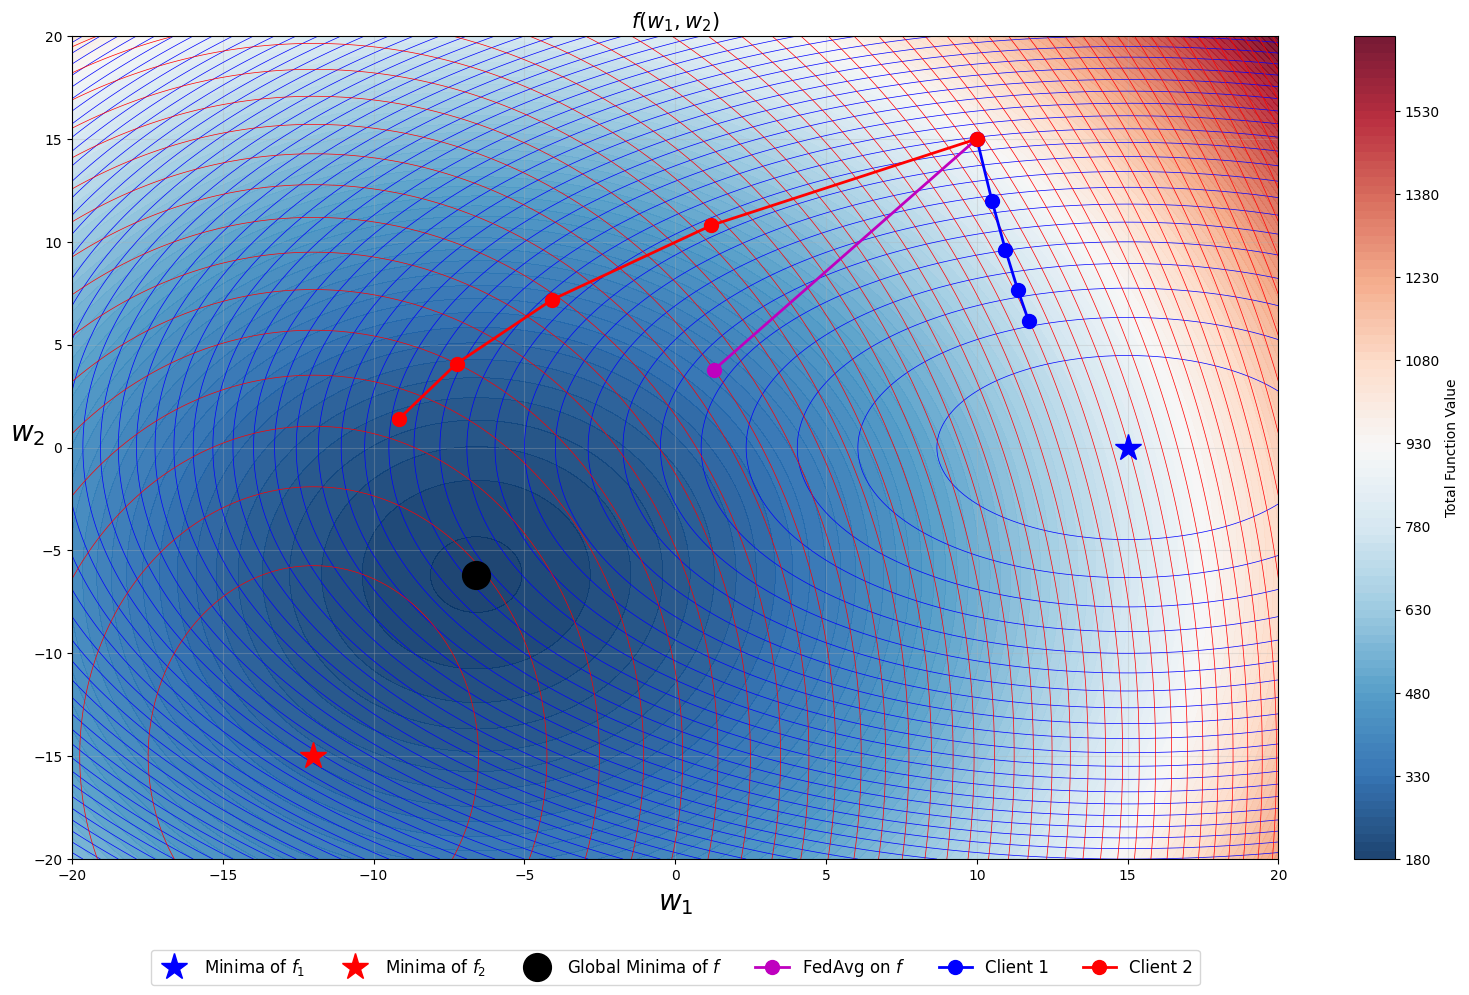

In [343]:
plt.figure(figsize=(16, 10))

contour_lines_1 =  plt.contour(W1, W2, Z1, levels=50, colors='blue', linewidths=0.5)
contour_lines_2 =  plt.contour(W1, W2, Z2, levels=50, colors='red', linewidths=0.5)
plt.plot(15, 0, 'b*', markersize=20, label=f'Minima of $f_1$')
plt.plot(-12, -15, 'r*', markersize=20, label=f'Minima of $f_2$')

contour = plt.contourf(W1, W2, Z, levels=100, cmap='RdBu_r', alpha=0.9)
plt.colorbar(contour, label='Total Function Value', orientation='vertical')
plt.plot(-6.59999996, -6.17647155, 'ko', markersize=20, label=f'Global Minima of $f$')


#FedAvg
FedAvg_W1 = [x[0] for x in fedavg_trajectory]
FedAvg_W2 = [x[1] for x in fedavg_trajectory]
plt.plot(FedAvg_W1[:2], FedAvg_W2[:2], 'm-o', label='FedAvg on $f$', linewidth=2, markersize=10)

#Client 1
Client1_W1 = [x[0] for x in client_1_traj]
Client1_W2 = [x[1] for x in client_1_traj]
plt.plot(Client1_W1[:5], Client1_W2[:5], 'b-o', label='Client 1', linewidth=2, markersize=10)

# #Client 2
Client2_W1 = [x[0] for x in client_2_traj]
Client2_W2 = [x[1] for x in client_2_traj]
plt.plot(Client2_W1[:5], Client2_W2[:5], 'r-o', label='Client 2', linewidth=2, markersize=10)



plt.title("$f(w_1, w_2)$", fontsize=15)
plt.xlabel("$w_1$", fontsize=20)
plt.ylabel("$w_2$", rotation=0, fontsize=20)
plt.legend(
    fontsize=12,                
    loc='upper center',         
    bbox_to_anchor=(0.5, -0.1), 
    ncol=6                      
)
plt.grid(alpha=0.3)
plt.tight_layout()  
plt.show()

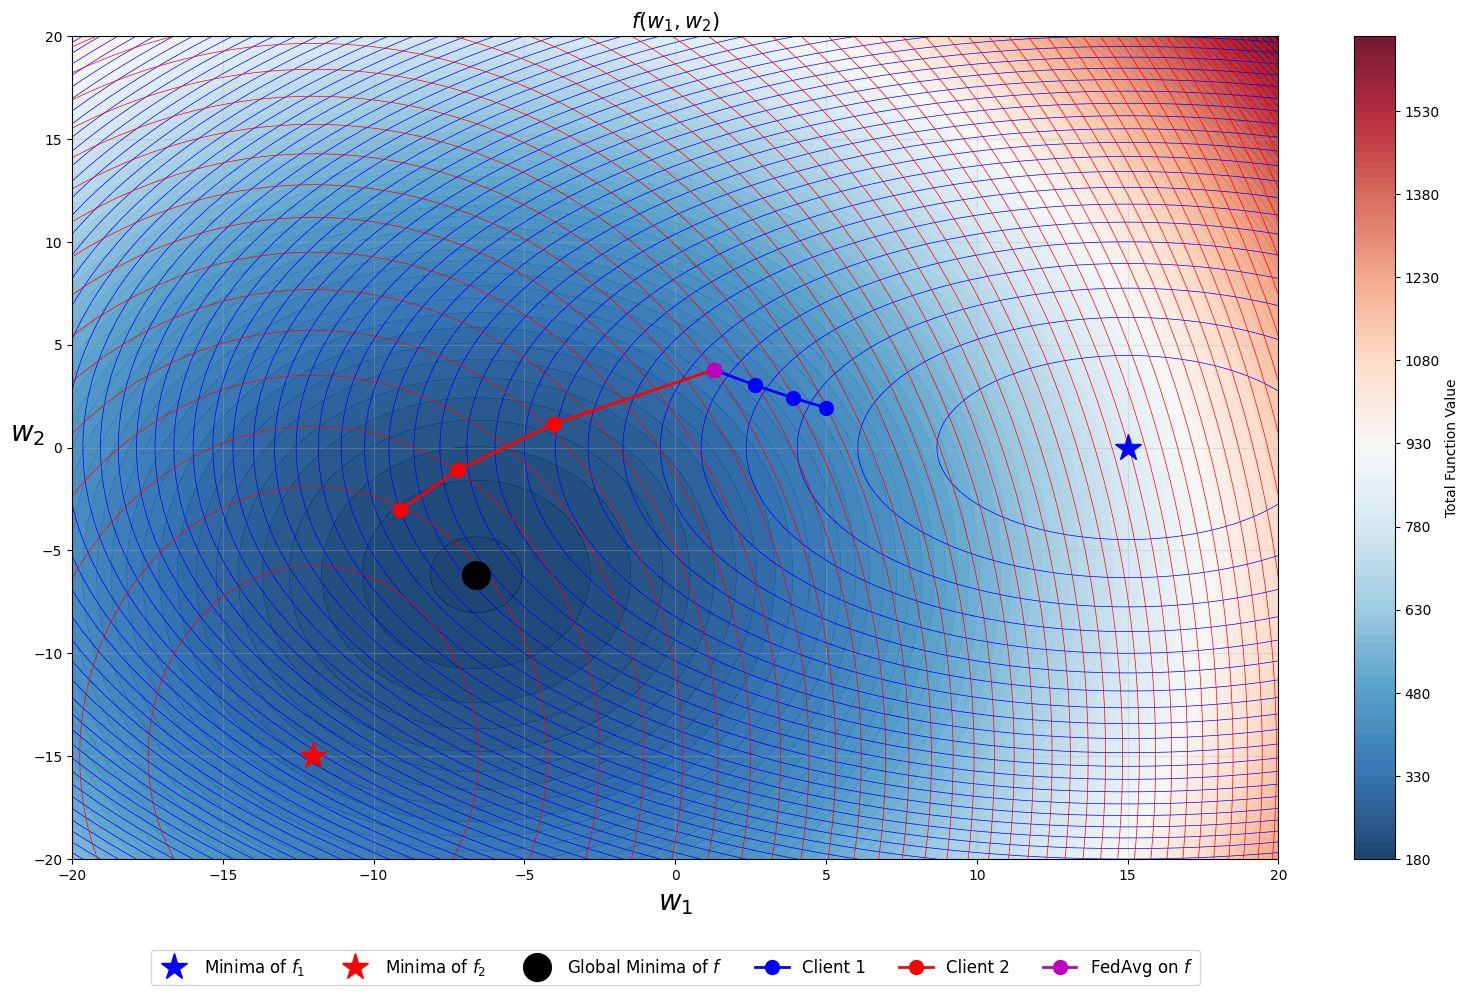

In [352]:
plt.figure(figsize=(16, 10))

contour_lines_1 =  plt.contour(W1, W2, Z1, levels=50, colors='blue', linewidths=0.5)
contour_lines_2 =  plt.contour(W1, W2, Z2, levels=50, colors='red', linewidths=0.5)
plt.plot(15, 0, 'b*', markersize=20, label=f'Minima of $f_1$')
plt.plot(-12, -15, 'r*', markersize=20, label=f'Minima of $f_2$')

contour = plt.contourf(W1, W2, Z, levels=100, cmap='RdBu_r', alpha=0.9)
plt.colorbar(contour, label='Total Function Value', orientation='vertical')
plt.plot(-6.59999996, -6.17647155, 'ko', markersize=20, label=f'Global Minima of $f$')



#Client 1
Client1_W1 = [x[0] for x in client_1_traj]
Client1_W2 = [x[1] for x in client_1_traj]
plt.plot(Client1_W1[5:9], Client1_W2[5:9], 'b-o', label='Client 1', linewidth=2, markersize=10)

# #Client 2
Client2_W1 = [x[0] for x in client_2_traj]
Client2_W2 = [x[1] for x in client_2_traj]
plt.plot(Client2_W1[5:9], Client2_W2[5:9], 'r-o', label='Client 2', linewidth=2, markersize=10)

#FedAvg
FedAvg_W1 = [x[0] for x in fedavg_trajectory]
FedAvg_W2 = [x[1] for x in fedavg_trajectory]
plt.plot(FedAvg_W1[1], FedAvg_W2[1], 'm-o', label='FedAvg on $f$', linewidth=2, markersize=10)


plt.title("$f(w_1, w_2)$", fontsize=15)
plt.xlabel("$w_1$", fontsize=20)
plt.ylabel("$w_2$", rotation=0, fontsize=20)
plt.legend(
    fontsize=12,                
    loc='upper center',         
    bbox_to_anchor=(0.5, -0.1), 
    ncol=6                      
)
plt.grid(alpha=0.3)
plt.tight_layout()  
plt.show()

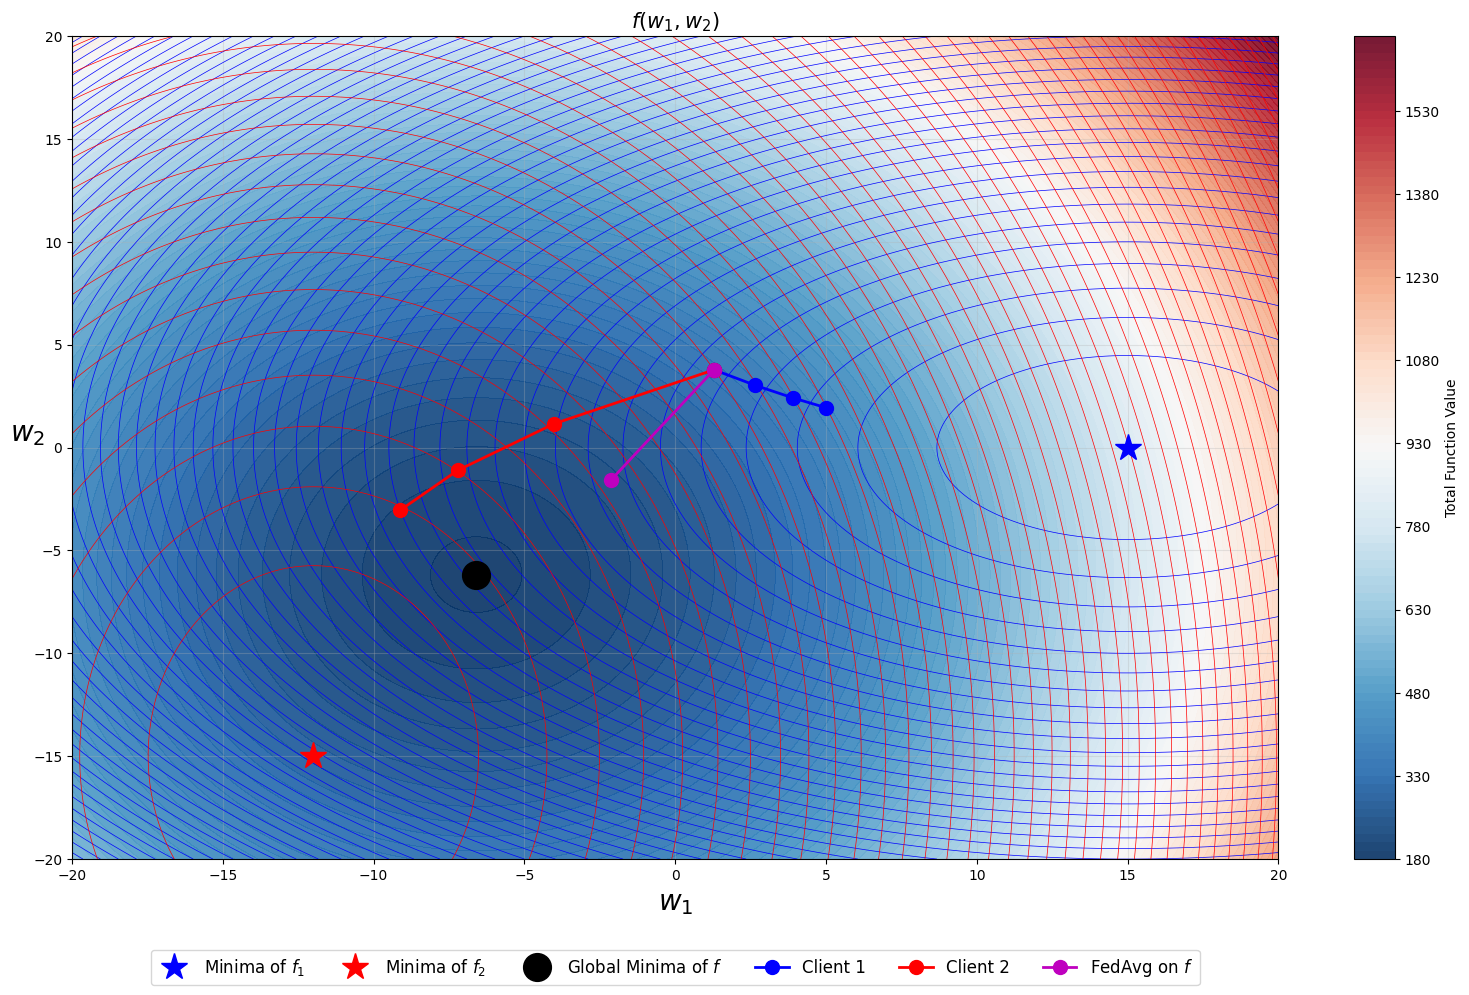

In [354]:
plt.figure(figsize=(16, 10))

contour_lines_1 =  plt.contour(W1, W2, Z1, levels=50, colors='blue', linewidths=0.5)
contour_lines_2 =  plt.contour(W1, W2, Z2, levels=50, colors='red', linewidths=0.5)
plt.plot(15, 0, 'b*', markersize=20, label=f'Minima of $f_1$')
plt.plot(-12, -15, 'r*', markersize=20, label=f'Minima of $f_2$')

contour = plt.contourf(W1, W2, Z, levels=100, cmap='RdBu_r', alpha=0.9)
plt.colorbar(contour, label='Total Function Value', orientation='vertical')
plt.plot(-6.59999996, -6.17647155, 'ko', markersize=20, label=f'Global Minima of $f$')



#Client 1
Client1_W1 = [x[0] for x in client_1_traj]
Client1_W2 = [x[1] for x in client_1_traj]
plt.plot(Client1_W1[5:9], Client1_W2[5:9], 'b-o', label='Client 1', linewidth=2, markersize=10)

# #Client 2
Client2_W1 = [x[0] for x in client_2_traj]
Client2_W2 = [x[1] for x in client_2_traj]
plt.plot(Client2_W1[5:9], Client2_W2[5:9], 'r-o', label='Client 2', linewidth=2, markersize=10)

#FedAvg
FedAvg_W1 = [x[0] for x in fedavg_trajectory]
FedAvg_W2 = [x[1] for x in fedavg_trajectory]
plt.plot(FedAvg_W1[1:3], FedAvg_W2[1:3], 'm-o', label='FedAvg on $f$', linewidth=2, markersize=10)


plt.title("$f(w_1, w_2)$", fontsize=15)
plt.xlabel("$w_1$", fontsize=20)
plt.ylabel("$w_2$", rotation=0, fontsize=20)
plt.legend(
    fontsize=12,                
    loc='upper center',         
    bbox_to_anchor=(0.5, -0.1), 
    ncol=6                      
)
plt.grid(alpha=0.3)
plt.tight_layout()  
plt.show()

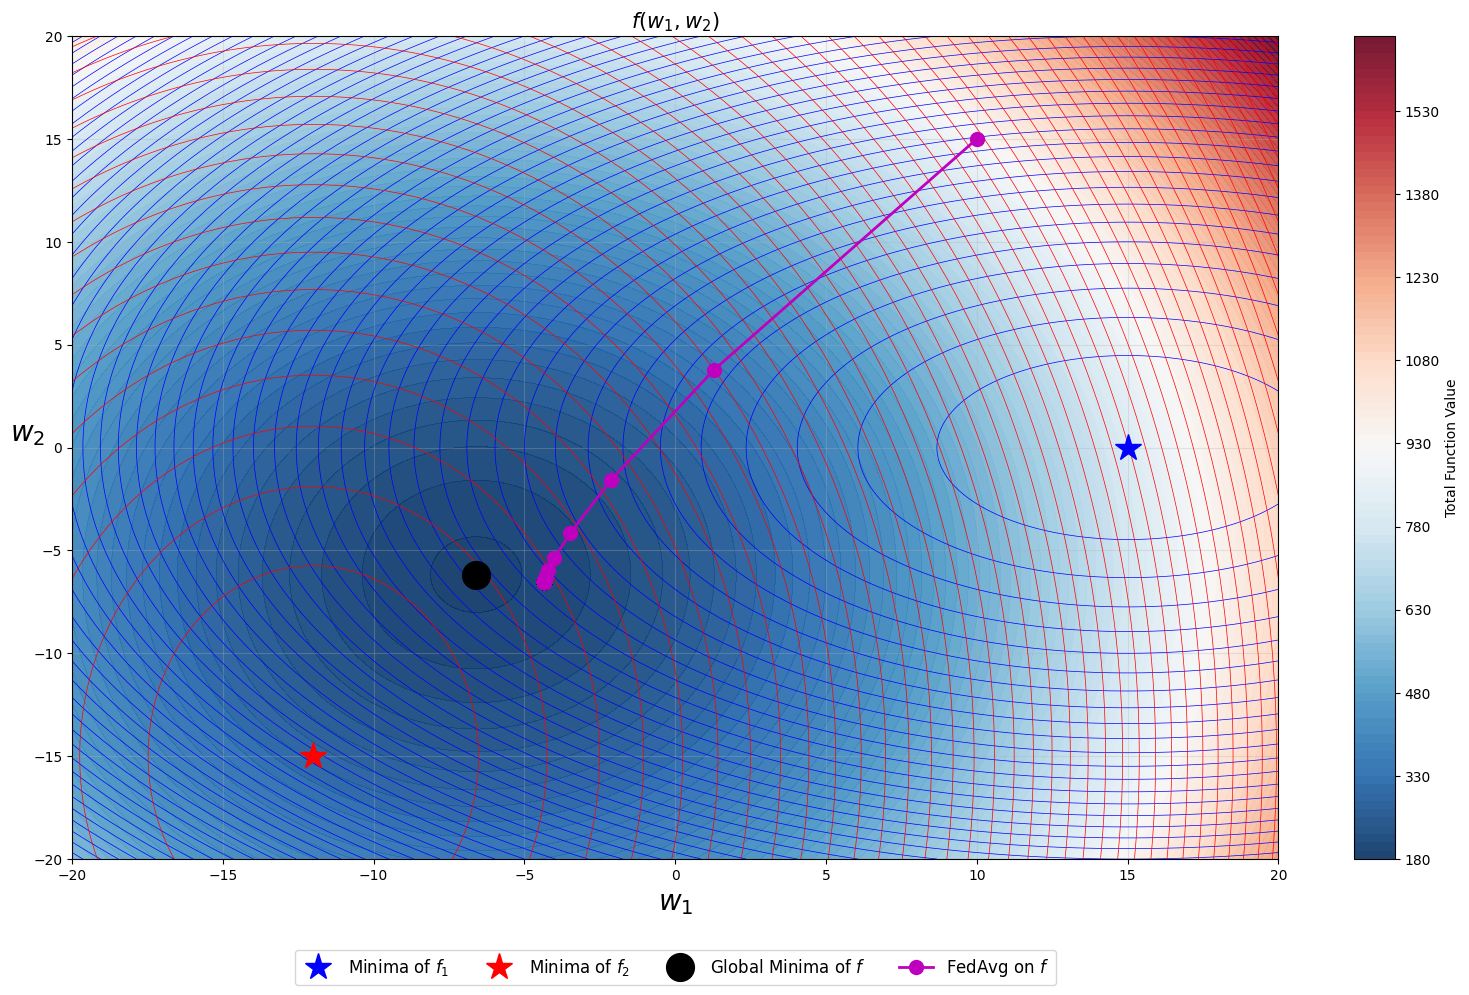

In [356]:
plt.figure(figsize=(16, 10))

contour_lines_1 =  plt.contour(W1, W2, Z1, levels=50, colors='blue', linewidths=0.5)
contour_lines_2 =  plt.contour(W1, W2, Z2, levels=50, colors='red', linewidths=0.5)
plt.plot(15, 0, 'b*', markersize=20, label=f'Minima of $f_1$')
plt.plot(-12, -15, 'r*', markersize=20, label=f'Minima of $f_2$')

contour = plt.contourf(W1, W2, Z, levels=100, cmap='RdBu_r', alpha=0.9)
plt.colorbar(contour, label='Total Function Value', orientation='vertical')
plt.plot(-6.59999996, -6.17647155, 'ko', markersize=20, label=f'Global Minima of $f$')

#SGD
# SGD_W1 = [x[0] for x in global_trajectory]
# SGD_W2 = [x[1] for x in global_trajectory]
# plt.plot(SGD_W1, SGD_W2, '--o', color='tab:orange', label='SGD on $f$', linewidth=2, markersize=10)

#FedAvg
FedAvg_W1 = [x[0] for x in fedavg_trajectory]
FedAvg_W2 = [x[1] for x in fedavg_trajectory]
plt.plot(FedAvg_W1[::], FedAvg_W2[::], 'm-o', label='FedAvg on $f$', linewidth=2, markersize=10)


plt.title("$f(w_1, w_2)$", fontsize=15)
plt.xlabel("$w_1$", fontsize=20)
plt.ylabel("$w_2$", rotation=0, fontsize=20)
plt.legend(
    fontsize=12,                
    loc='upper center',         
    bbox_to_anchor=(0.5, -0.1), 
    ncol=6                      
)
plt.grid(alpha=0.3)
plt.tight_layout()  
plt.show()

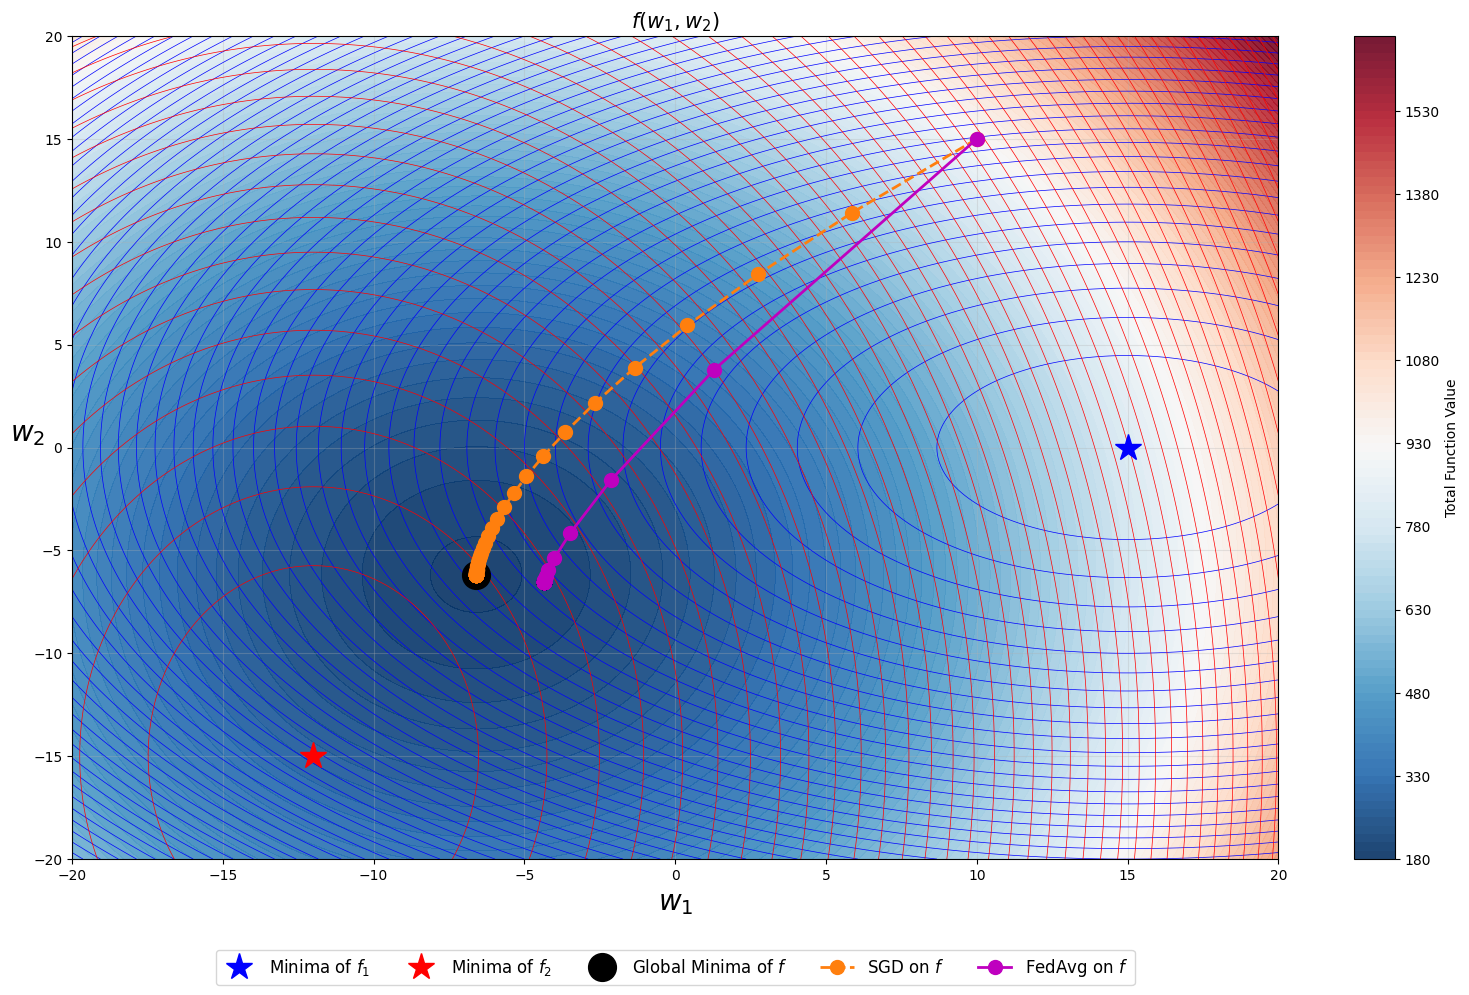

In [357]:
plt.figure(figsize=(16, 10))

contour_lines_1 =  plt.contour(W1, W2, Z1, levels=50, colors='blue', linewidths=0.5)
contour_lines_2 =  plt.contour(W1, W2, Z2, levels=50, colors='red', linewidths=0.5)
plt.plot(15, 0, 'b*', markersize=20, label=f'Minima of $f_1$')
plt.plot(-12, -15, 'r*', markersize=20, label=f'Minima of $f_2$')

contour = plt.contourf(W1, W2, Z, levels=100, cmap='RdBu_r', alpha=0.9)
plt.colorbar(contour, label='Total Function Value', orientation='vertical')
plt.plot(-6.59999996, -6.17647155, 'ko', markersize=20, label=f'Global Minima of $f$')

#SGD
SGD_W1 = [x[0] for x in global_trajectory]
SGD_W2 = [x[1] for x in global_trajectory]
plt.plot(SGD_W1, SGD_W2, '--o', color='tab:orange', label='SGD on $f$', linewidth=2, markersize=10)

#FedAvg
FedAvg_W1 = [x[0] for x in fedavg_trajectory]
FedAvg_W2 = [x[1] for x in fedavg_trajectory]
plt.plot(FedAvg_W1[::], FedAvg_W2[::], 'm-o', label='FedAvg on $f$', linewidth=2, markersize=10)


plt.title("$f(w_1, w_2)$", fontsize=15)
plt.xlabel("$w_1$", fontsize=20)
plt.ylabel("$w_2$", rotation=0, fontsize=20)
plt.legend(
    fontsize=12,                
    loc='upper center',         
    bbox_to_anchor=(0.5, -0.1), 
    ncol=6                      
)
plt.grid(alpha=0.3)
plt.tight_layout()  
plt.show()